In [2]:
import requests
import json
import time
import re
import random
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /home/abiget/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Collection**

**LLM**

In [5]:
API_KEY = "SB7RLl13RiALifpPVLXfK3jAfXxiqAwO"
# svPU7ggOb1jfTScqf3F4f6CXjaPni13C

# Base URL for Mistral's OpenAI-compatible chat completions endpoint
API_URL = "https://api.mistral.ai/v1/chat/completions"

# Choose one of the available models (e.g., 'mistral-tiny', 'mistral-small', 'mistral-medium')
MODEL = "mistral-small"

# Headers for authentication and content type
HEADERS = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [6]:
def chat_with_mistral(messages):
    """
    Sends a list of messages to the Mistral chat API and returns the assistant's response.

    Parameters:
        messages (list): A list of message dictionaries in the OpenAI chat format.
                         Example: [{"role": "user", "content": "Hello!"}]

    Returns:
        str: The assistant's reply as a string.
    """
    payload = {
        "model": MODEL,
        "messages": messages,
        "temperature": 0.7,     # Creativity level (0 = deterministic, 1 = more random)
        "top_p": 1.0,           # Nucleus sampling parameter
        "stream": False         # Disable streaming for simple usage
    }

    # Send a POST request to Mistral's API
    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(payload))

    return response

In [7]:
# a function to save the response to a file
def save_response_to_file(response, filename="response.txt"):
    with open(filename, "a") as file:
        file.write(response + "\n")
    # print(f"Response saved to {filename}")

In [3]:
# Load the common adjectives from a JSON file
with open("common-adjectives.json", "r") as file:
    data = json.load(file)

In [4]:
# Print the number of common adjectives as base words
print(len(data['CommonAdjectives']))

240


In [12]:
def generate_data(prompt):
    # Initialize a conversation with a greeting
    examples = [
        "happy → joyful,content,pleased",
        "sad → unhappy,dejected,downcast",
        "fast → quick,swift,rapid",
    ]
    example = random.choice(examples)
    
    chat_history = [
        {"role": "user", 
         "content": (
             f"Generate only 3 to 10 synonyms for the word '{prompt}' as a single comma-separated string. "
             f"Do not add explanations, greetings, or anything else — only return the synonyms in this exact format: word1,word2,word3. "
             f"Example: {example}. No brackets, no quotes, no extra text, no whitespace between the first word and the second word except the comma. Just synonyms."
         )
        }
    ]

    try:
        # Send the message and receive the model's response
        return chat_with_mistral(chat_history)

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [13]:

def fetch_with_retry(word, retries=3, delay=2):
    for i in range(retries):
        # Call the function to generate data
        response = generate_data(word)

        if response.status_code == 200:
            response_data = response.json()
            return response_data['choices'][0]['message']['content']
        elif response.status_code == 429:
            wait_time = delay * (2 ** i)
            print(f"Rate limited on '{word}'. Waiting {wait_time}s...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching synonyms for '{word}': {response.status_code} - {response.text}")
            return None
    return None

In [ ]:
# List to store failed words when fetching synonyms
failed_words = []

In [16]:
def generate_words_from_base_words(base_words):
    # Generate 3-10 synonyms for each word in the list
    # base_words = data['CommonAdjectives']
    # # base_words = extended_words
    
    for word in base_words:
        prompt = f"{word}"
        response = fetch_with_retry(prompt, retries=2, delay=2)
        
        if response is None:
            print(f"Failed to fetch synonyms for '{word}' after retries.")
            continue
        # break
        if re.match(r"^[a-zA-Z-]+(,[a-zA-Z-]+){1,9}$", response):
            for synonym in response.split(","):
                save_response_to_file(word + "," + synonym.strip(), "synonyms.csv")
            print(f"{word}: {synonym.strip()}")
        else:
            print(f"Invalid response format for '{word}': {response}")
            failed_words.append(word)
            continue

In [ ]:
# Generate synonyms for the common adjectives
generate_words_from_base_words(data['CommonAdjectives'])

In [ ]:
# Load the synonyms from the CSV file
synonyms_df = pd.read_csv("synonyms.csv", header=None)
synonyms_df.columns = ["word", "synonym"]
synonyms_df = synonyms_df.drop_duplicates()

unique_synonyms = synonyms_df['synonym'].drop_duplicates().reset_index(drop=True)

In [86]:
# Save the DataFrame to a CSV file
unique_synonyms.to_csv("base_synonyms_extended.csv", index=False)

In [7]:
# number of base words
print(f"Number of base words: {len(data['CommonAdjectives'])}")
# number of unique synonyms
print(f"Number of extended base words: {len(unique_synonyms)}")

Number of base words: 240
Number of extended base words: 2373


In [ ]:
# generate synonyms for the unique synonyms to expand our dataset
generate_words_from_base_words(unique_synonyms)

DATA Description:
1. LLM

We have used the most common 240 words from internet used them as a base word to generate 3-10 synonyms words using minstral llm and to extend our vocabulary we have used, 2373 unique words from the generated synonym words and agian generate 3-10 synonym words. 
- Number of base words: 240
- Number of extended base words: 2373

2. WordNet

We have used all the unique base words (i.e 598) from the above process and try to get at most 10 synonym words from the wordnet.

**WordNet**

In [23]:
# example of using WordNet to find synonyms
synonyms = set()
for syn in wn.synsets("hide", ):
    for lemma in syn.lemmas():
        synonyms.add(lemma.name())
print(synonyms)

{'fell', 'obscure', 'skin', 'hide_out', 'blot_out', 'obliterate', 'hide', 'pelt', 'enshroud', 'veil', 'conceal', 'cover', 'shroud'}


In [88]:
def collect_synonyms_wordnet(word, pos=wn.ADJ, max_words=10):
    """
    Create an edge list for a given word using WordNet.
    """
    synonyms = set()
    # Get the synsets for the word
    synsets = wn.synsets(word, pos=pos)
    for synset in synsets:
        for lemma in synset.lemmas():
            if lemma.name() != word:
                synonyms.add(lemma.name().strip().replace('_', '-').lower())
                print(f"{word}: {lemma.name().strip()}")

                if len(synonyms) >= max_words:
                    # Save the synonyms to a CSV file
                    for synonym in synonyms:
                        save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
                        print(f"{word}: {synonym.strip()}")
                    return

    if synonyms is not None:
        # If we reach here, the num of synonyms is less than max_words so we save them
        for synonym in synonyms:
            save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
            print(f"{word}: {synonym.strip()}") 

In [ ]:
# List of words to process
words_for_wordnet = pd.read_csv("synonyms.csv", header=None, names=["word", "synonym"])['word'].drop_duplicates().reset_index(drop=True)

# Generate synonyms for the unique words using WordNet
words_for_wordnet.apply(lambda x: collect_synonyms_wordnet(x, pos=wn.ADJ))

In [11]:
print("Number of unique words to be use as base words for WordNet:", len(words_for_wordnet))

Number of unique words to be use as base words for WordNet: 598


## Build Synonyms Network

In [12]:
# load the synonyms similarity and create network
def load_synonyms_network(file_path):
    G = nx.Graph()

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if not line or ',' not in line:
                continue

            word1, word2 = line.split(',')
            G.add_edge(word1, word2)
            
    return G

In [13]:
wordnet_file_path = 'synonyms_wordnet.csv'
llm_file_path = 'synonyms.csv'
G_wordnet = load_synonyms_network(wordnet_file_path)
G_llm = load_synonyms_network(llm_file_path)

In [14]:
num_nodes = G_wordnet.number_of_nodes()
num_edges = G_wordnet.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))

print(f'WordNet Network:')
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

print("="*40)

print(f'LLM Network:')
num_nodes = G_llm.number_of_nodes()
num_edges = G_llm.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

WordNet Network:
#Edges: 2019
#Nodes: 1855
Density: 0.0011741205000043616
LLM Network:
#Edges: 4336
#Nodes: 2384
Density: 0.0015264724685763531


In [16]:
def visualize_neighborhood_extended(G, word, radius=1, layout='spring', label=None):
    
    if word not in G:
        print(f'The word "{word}" is not in the graph.')
        return

    neighborhood = nx.ego_graph(G, word, radius=radius)

    # Use Seaborn's whitegrid style for a cleaner aesthetic
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 10))

    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(neighborhood, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(neighborhood)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(neighborhood)
    elif layout == 'spectral':
        pos = nx.spectral_layout(neighborhood)
    else:
        pos = nx.spring_layout(neighborhood, seed=42)

    # Node and edge drawing
    nx.draw_networkx_edges(
        neighborhood, pos, connectionstyle='arc3, rad=0.2',
        edge_color='gray', alpha=0.5, arrows=True
    )

    nx.draw_networkx_nodes(
        neighborhood, pos, node_color='#69b3a2',
        node_size=0, edgecolors='black', linewidths=0.8
    )

    nx.draw_networkx_labels(
        neighborhood, pos, font_size=12,
        font_weight='bold', font_color='black'
    )

    plt.axis('off')
    plt.title(
        f"Synonyms Network of '{word}' (radius={radius})" + (f" - {label}" if label else ""),
        fontsize=16, fontweight='bold'
    )
    plt.tight_layout()

    plt.show() 

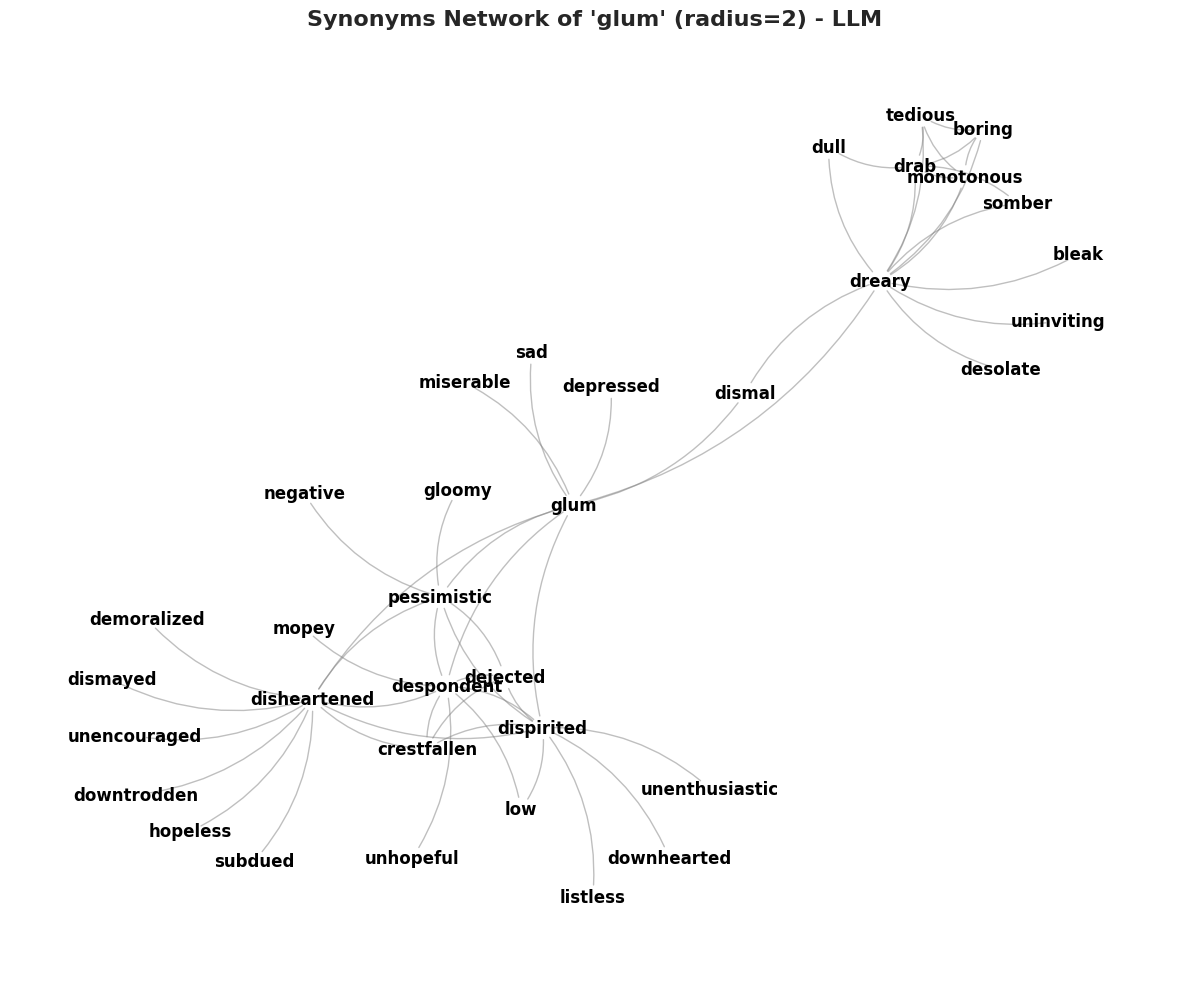

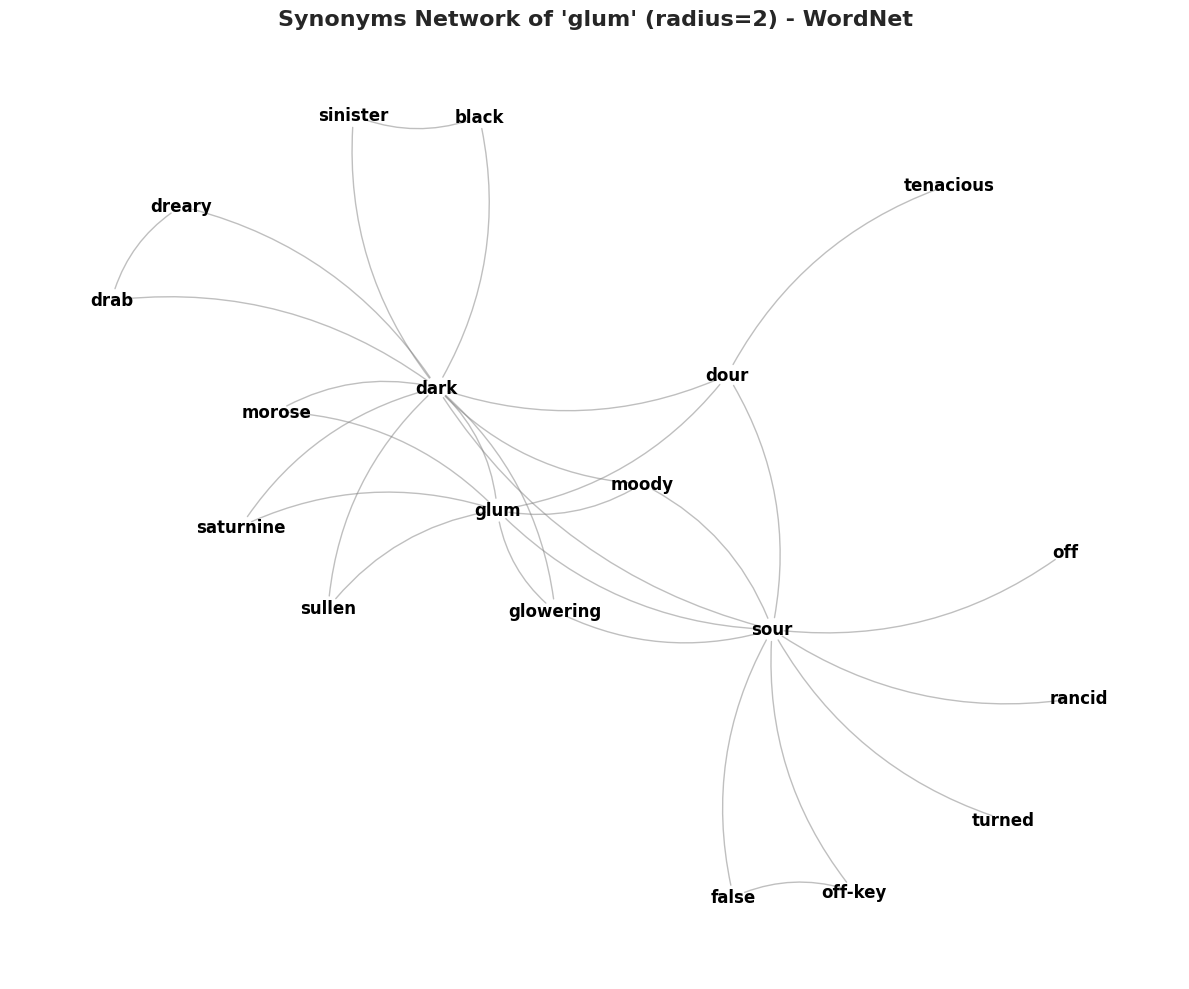

In [18]:
# Visualize the neighborhood of a specific word
word = 'glum'
visualize_neighborhood_extended(G_llm, word, radius=2, label='LLM')
visualize_neighborhood_extended(G_wordnet, word, radius=2, label='WordNet')

In [19]:
degree_llm = dict(G_llm.degree())
degree_wordnet = dict(G_wordnet.degree())


degree_sorted_wordnet = sorted(degree_wordnet.items(), key=lambda x: x[1], reverse=True)
degree_sorted_llm = sorted(degree_llm.items(), key=lambda x: x[1], reverse=True)
top_20_nodes_wordnet = degree_sorted_wordnet[:20]
top_20_nodes_llm = degree_sorted_llm[:20]
print("Top 20 nodes by degree in WordNet:")
print(top_20_nodes_wordnet)
print("Top 20 nodes by degree in LLM:")
print(top_20_nodes_llm)

Top 20 nodes by degree in WordNet:
[('good', 16), ('fresh', 12), ('big', 12), ('strong', 12), ('hard', 12), ('open', 12), ('dark', 12), ('sharp', 12), ('lofty', 12), ('keen', 11), ('little', 11), ('free', 11), ('soft', 11), ('quick', 11), ('wide', 11), ('broad', 11), ('black', 11), ('rude', 11), ('muddy', 11), ('crisp', 11)]
Top 20 nodes by degree in LLM:
[('original', 20), ('paramount', 20), ('sharp', 20), ('delightful', 19), ('preeminent', 19), ('modest', 19), ('generous', 19), ('clear', 19), ('primary', 18), ('large', 17), ('extensive', 17), ('tiny', 17), ('key', 17), ('notable', 17), ('reasonable', 17), ('dirty', 17), ('significant', 16), ('insignificant', 16), ('legitimate', 16), ('positive', 16)]


In [59]:
sns.reset_defaults()
plt.style.use('default')

In [66]:
def plot_degree_both_dist(deg_dist_llm, deg_dist_wordnet):
    # sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))
    plt.plot(range(len(deg_dist_llm)), deg_dist_llm, marker='o', markersize=6)
    plt.plot(range(len(deg_dist_wordnet)), deg_dist_wordnet, marker='o', markersize=6)

    plt.title(f"Wordnet vs LLM Degree Distribution Log-Log")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1, 25])
    plt.xticks(fontsize=10)
    plt.xlabel("Degree log scale")
    plt.ylabel("Frequency log scale")
    plt.legend(["LLM", "WordNet"], loc='upper right')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [69]:
def plot_degree_dist(deg_dist, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(deg_dist)), deg_dist, marker='o', markersize=6)
    plt.title(f"{title} Degree Distribution Log-Log")
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=10)
    plt.xlabel("Degree log scale")
    plt.ylabel("Frequency log scale")
    plt.grid(True, ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

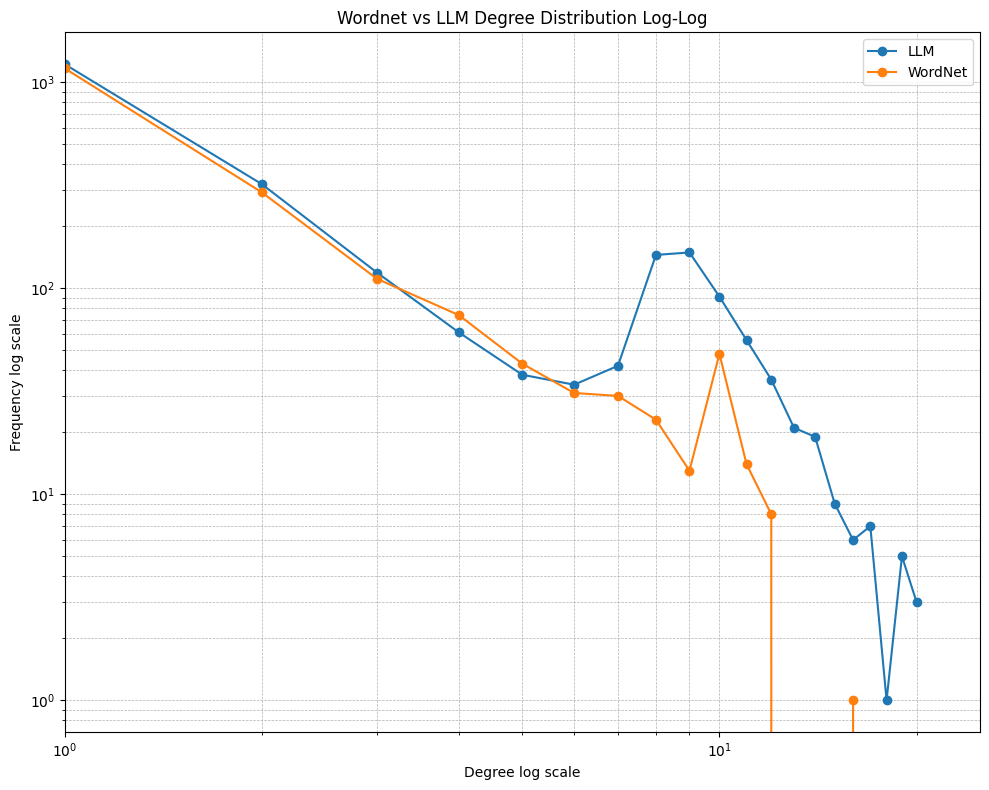

In [67]:
llm_degree_hist = nx.degree_histogram(G_llm)
wordnet_degree_hist = nx.degree_histogram(G_wordnet)
plot_degree_both_dist(llm_degree_hist, wordnet_degree_hist)

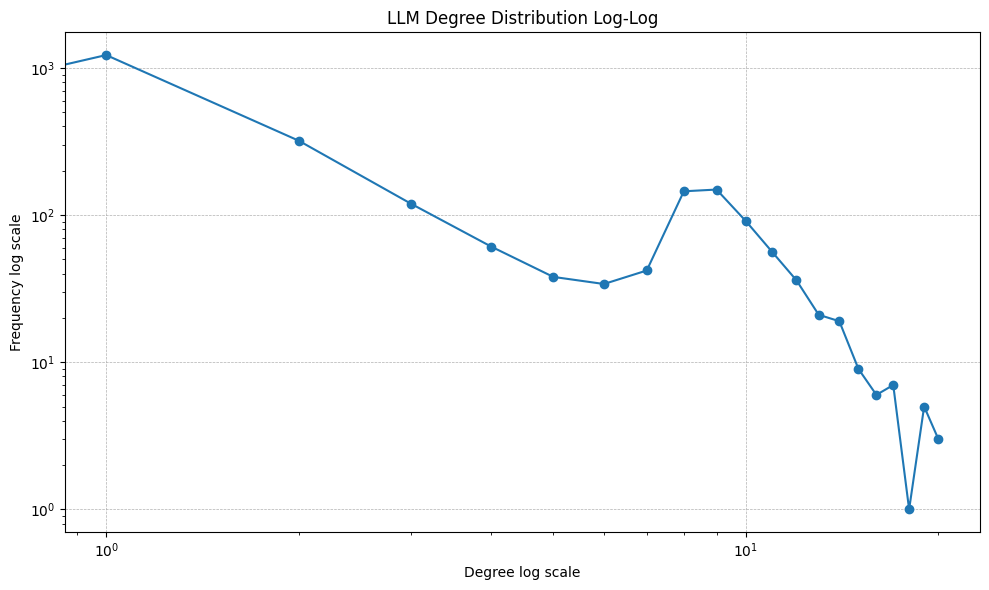

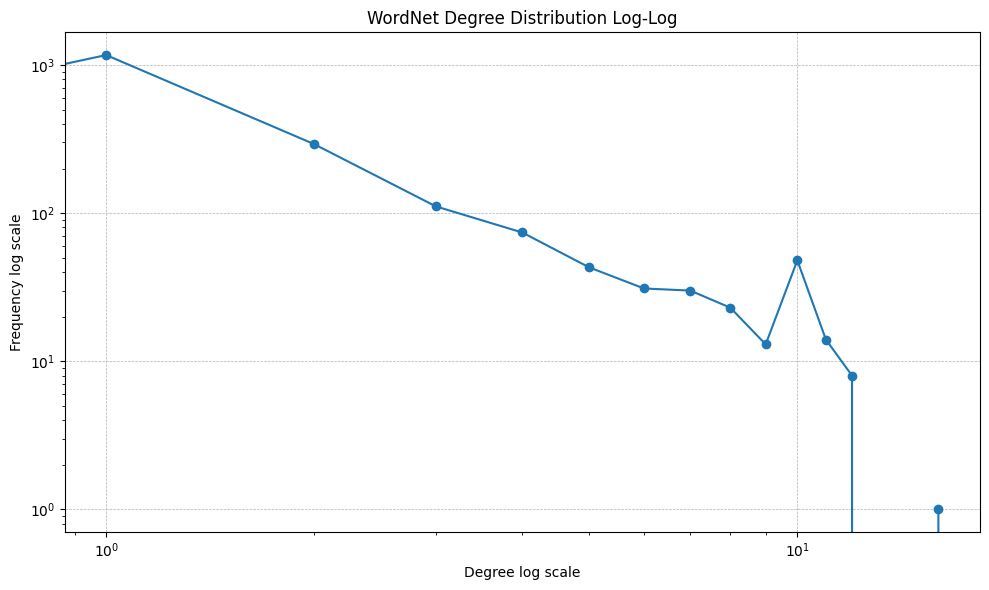

In [70]:
plot_degree_dist(llm_degree_hist, "LLM")
plot_degree_dist(wordnet_degree_hist, "WordNet")

In [71]:
# calculate local clustering coefficient
def calculate_clustering_coefficient(G):
    clustering_coeffs = nx.clustering(G)
    return clustering_coeffs
clustering_coeffs_llm = calculate_clustering_coefficient(G_llm)
clustering_coeffs_wordnet = calculate_clustering_coefficient(G_wordnet)

In [72]:
def get_top_k_nodes_by_clustering(clustering_coeffs, k=10):
    
    sorted_nodes = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:k]

In [73]:
print("Top 10 nodes by clustering coefficient:")
top_10_clustering_coeff = get_top_k_nodes_by_clustering(clustering_coeffs_llm, k=10)
print(top_10_clustering_coeff)

top_10_clustering_coeff = get_top_k_nodes_by_clustering(clustering_coeffs_wordnet, k=10)
print(top_10_clustering_coeff)

Top 10 nodes by clustering coefficient:
[('admirable', 1.0), ('earliest', 1.0), ('maiden', 1.0), ('terminal', 1.0), ('prolonged', 1.0), ('upward', 1.0), ('unlike', 1.0), ('disparate', 1.0), ('varied', 1.0), ('diminutive', 1.0)]
[('adept', 1.0), ('practiced', 1.0), ('initiative', 1.0), ('maiden', 1.0), ('initiatory', 1.0), ('final', 1.0), ('terminal', 1.0), ('recollective', 1.0), ('retentive', 1.0), ('dandy', 1.0)]


In [74]:
# Calculate the average clustering coefficient
average_clustering_coeff = nx.average_clustering(G_wordnet), nx.average_clustering(G_llm)
print(f"Average clustering coefficient (WordNet): {average_clustering_coeff[0]:.4f}")
print(f"Average clustering coefficient (LLM): {average_clustering_coeff[1]:.4f}")
# Calculate the global clustering coefficient
global_clustering_coeff = nx.transitivity(G_wordnet), nx.transitivity(G_llm)
print(f"Global clustering coefficient (WordNet): {global_clustering_coeff[0]:.4f}")
print(f"Global clustering coefficient (LLM): {global_clustering_coeff[1]:.4f}")

Average clustering coefficient (WordNet): 0.1467
Average clustering coefficient (LLM): 0.1829
Global clustering coefficient (WordNet): 0.1783
Global clustering coefficient (LLM): 0.2182


In [75]:
common_nodes = set(G_llm.nodes()).intersection(G_wordnet.nodes())
print("Common nodes:", common_nodes)

Common nodes: {'filthy', 'low', 'coherent', 'strong', 'tight', 'steep', 'rude', 'tart', 'logical', 'utmost', 'confident', 'revered', 'swift', 'acrid', 'brilliant', 'content', 'listless', 'good-looking', 'tenanted', 'midway', 'restrained', 'sequential', 'awkward', 'immaculate', 'exalted', 'devoid', 'intense', 'dismal', 'economical', 'obese', 'civil', 'unilluminated', 'pleasurable', 'base', 'trustworthy', 'hesitant', 'minuscule', 'boisterous', 'extensive', 'subordinate', 'frugal', 'polite', 'lean', 'monumental', 'minute', 'unobtrusive', 'acceptable', 'dishonorable', 'tough', 'extended', 'wholehearted', 'venerable', 'agreeable', 'unassailable', 'vivid', 'big', 'gratifying', 'nervous', 'terse', 'janus-faced', 'ill-mannered', 'strenuous', 'mindless', 'lucky', 'incorrect', 'planetary', 'paunchy', 'high', 'orderly', 'close-fitting', 'regardful', 'clear', 'former', 'sleek', 'ample', 'legitimate', 'perilous', 'powerful', 'weighty', 'faint', 'grimy', 'ardent', 'sparse', 'diaphanous', 'peppy', 'a

In [76]:
G_llm_comm = G_llm.subgraph(common_nodes).copy()
G_wordnet_comm = G_wordnet.subgraph(common_nodes).copy()

In [77]:
disconnected_llm = [node for node in G_llm_comm.nodes if G_llm_comm.degree(node) == 0]
disconnected_wordnet = [node for node in G_wordnet_comm.nodes if G_wordnet_comm.degree(node) == 0]
print(f"Disconnected nodes in LLM: {len(disconnected_llm)}")
print(f"Disconnected nodes in WordNet: {len(disconnected_wordnet)}")

Disconnected nodes in LLM: 23
Disconnected nodes in WordNet: 66


In [78]:
# Create a subgraph excluding nodes in `disconnected_wordnet`
G_wordnet_comm_without_disconnected = G_wordnet_comm.subgraph(
    [n for n in G_wordnet_comm.nodes if n not in disconnected_wordnet]
).copy()

# Create a subgraph excluding nodes in `disconnected_llm`
G_llm_comm_without_disconnected = G_llm_comm.subgraph(
    [n for n in G_llm_comm.nodes if n not in disconnected_llm]
).copy()

In [79]:
num_nodes = G_wordnet_comm_without_disconnected.number_of_nodes()
num_edges = G_wordnet_comm_without_disconnected.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))
print(f'WordNet Network:')
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

print("="*40)

print(f'LLM Network:')
num_nodes = G_llm_comm_without_disconnected.number_of_nodes()
num_edges = G_llm_comm_without_disconnected.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes - 1))
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

WordNet Network:
#Edges: 893
#Nodes: 873
Density: 0.0023461227234990592
LLM Network:
#Edges: 1885
#Nodes: 916
Density: 0.0044980552175054285


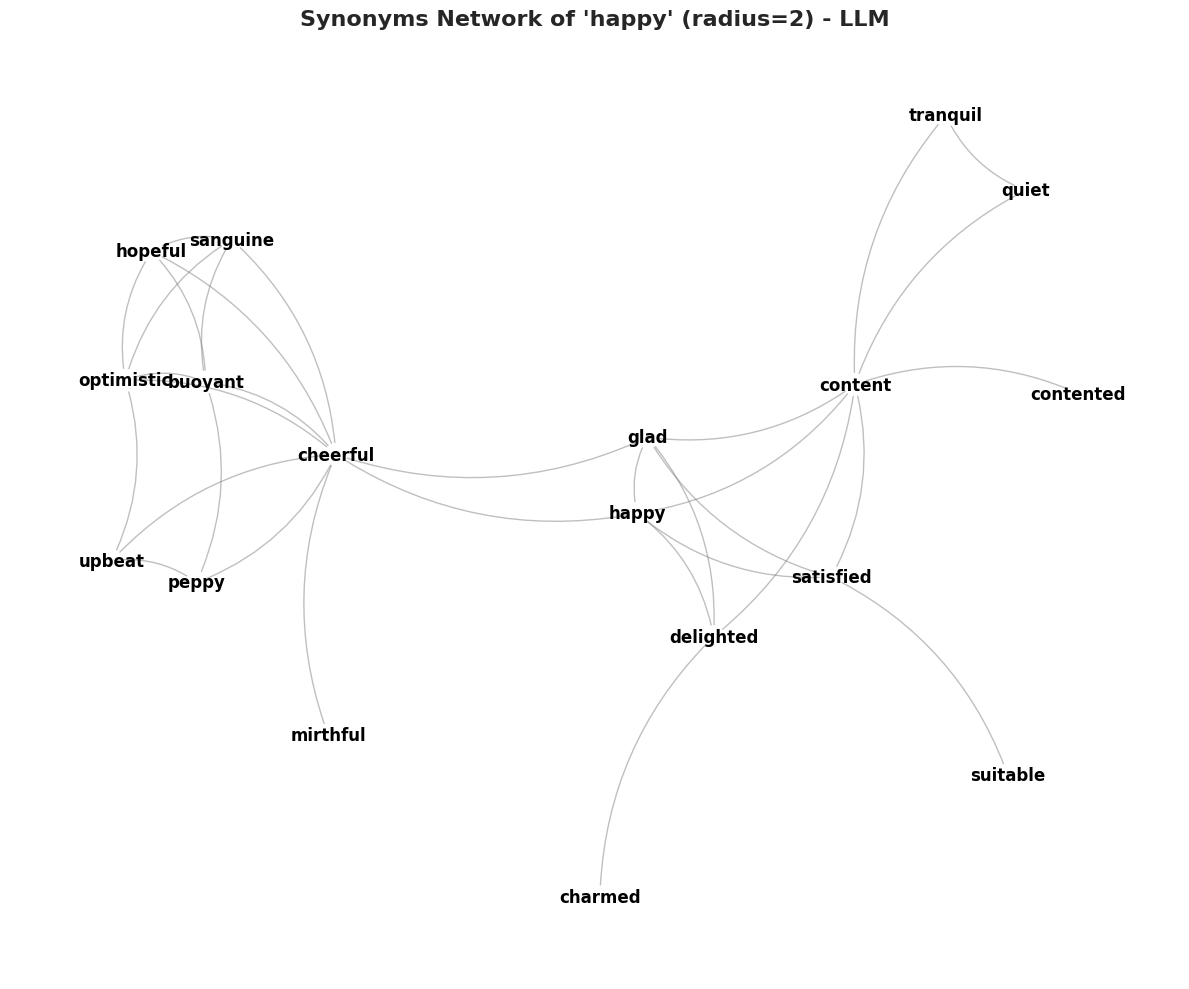

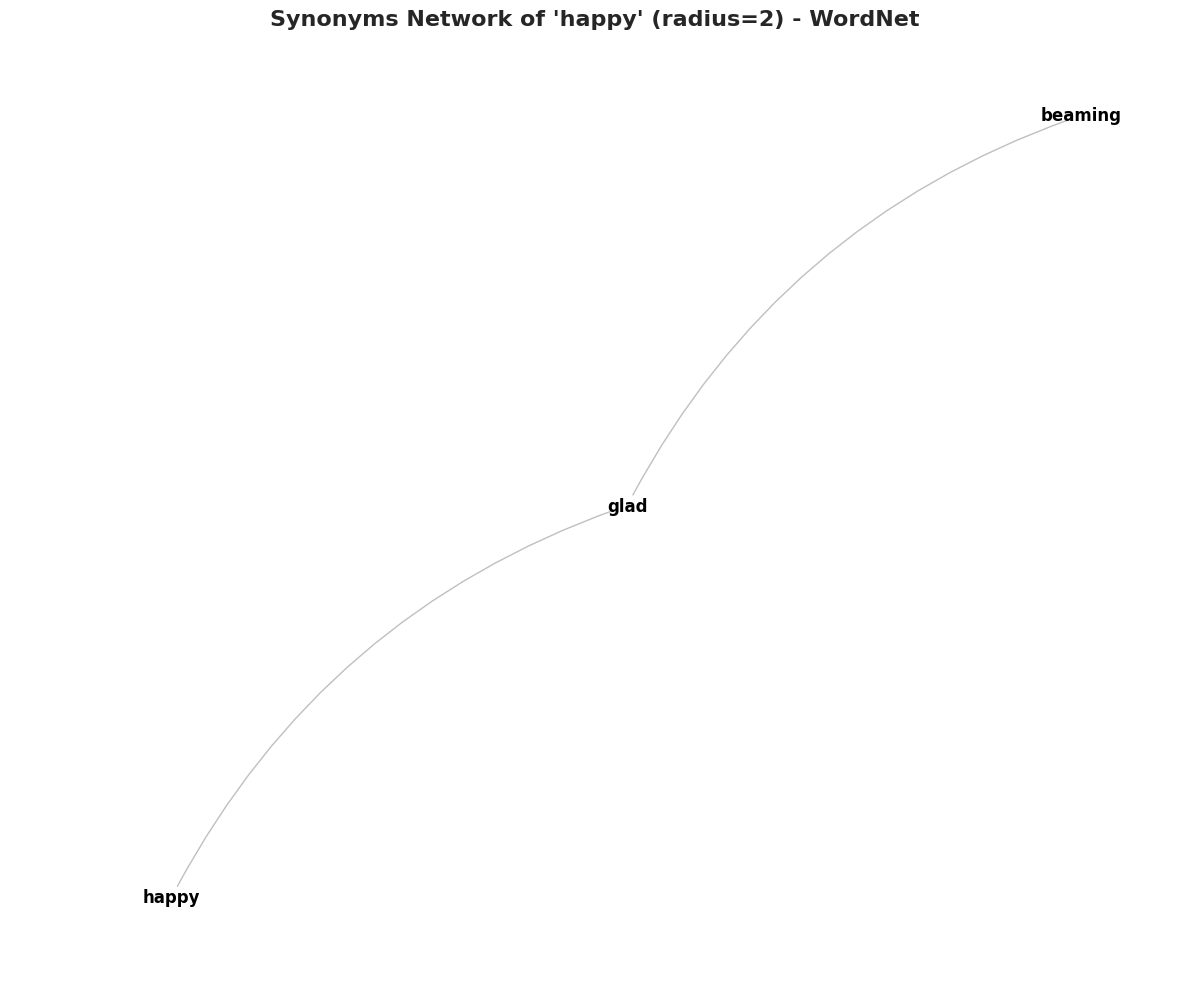

In [81]:
# Visualize the neighborhood of a specific word
word = 'happy'
visualize_neighborhood_extended(G_llm_comm, word, radius=2, label="LLM")
visualize_neighborhood_extended(G_wordnet_comm_without_disconnected, word, radius=2, label="WordNet")